In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
#Set data order
data_order = 8

In [3]:
# wandb.init(project="ads1_prj_VGG19n")


In [4]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [5]:
exps_dir = "../../../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder()
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        # y_train=oneHot(y_train)
        # y_test=oneHot(y_test)
        # Tạo một tensor TensorFlow
        # data_table = tf.placeholder(shape=(None, 42), dtype=tf.float32)  # Đây là một ví dụ, bạn có thể có dữ liệu thực tế khác

        # Thêm một chiều mới vào cuối tensor
        x_train = tf.expand_dims(x_train, axis=-1)
        x_test = tf.expand_dims(x_test, axis=-1)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42, 1) (656, 1) (324, 42, 1) (324, 1)
(656, 42, 1) (656, 1) (324, 42, 1) (324, 1)
(1001, 42, 1) (1001, 1) (324, 42, 1) (324, 1)
(1002, 42, 1) (1002, 1) (324, 42, 1) (324, 1)
(355, 42, 1) (355, 1) (324, 42, 1) (324, 1)
(656, 42, 1) (656, 1) (324, 42, 1) (324, 1)
(656, 42, 1) (656, 1) (324, 42, 1) (324, 1)
(1001, 42, 1) (1001, 1) (324, 42, 1) (324, 1)
(1002, 42, 1) (1002, 1) (324, 42, 1) (324, 1)
(355, 42, 1) (355, 1) (324, 42, 1) (324, 1)
10


In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [8]:
x_test.shape

(330, 42)

In [9]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [10]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro


In [11]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [12]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [14]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    # Convert predictions to binary (0 or 1)
    y_pred = K.round(y_pred)
    
    # Calculate True Positives, False Positives and False Negatives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    
    # Calculate precision and recall for each class
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    
    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score



In [15]:
def multi_loss(y_true, y_pred):
    # # Tính toán các loss function riêng lẻ
    focal__loss = focal_loss(y_true,y_pred)
    f1__loss = f1_loss(y_true,y_pred)
    dice__loss = dice_coef_loss(y_true,y_pred)
    focal_weight = 0.3
    f1_weight = 0.5
    dice_weight = 0.2

    total_loss = (focal_weight * focal__loss) + (f1_weight * f1__loss) + (dice_weight * dice__loss)

    return total_loss

In [16]:
# def combined_loss(y_true, y_pred):
#     inputs = y_true[:, :-num_classes]
#     true_labels = y_true[:, -num_classes:]
    
#     outputs_vae, classification_output = y_pred
    
#     # Tính toán reconstruction loss cho VAE
#     reconstruction_loss = categorical_crossentropy(inputs, outputs_vae)
#     reconstruction_loss *= input_dim
    
#     # Tính toán KL loss cho VAE
#     z_mean, z_log_var = encoder(inputs)[0], encoder(inputs)[1]
#     kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
    
#     # Tính toán loss tổng hợp cho VAE
#     vae_loss = K.mean(reconstruction_loss + kl_loss)
    
#     # Tính toán classification loss
#     classification_loss = categorical_crossentropy(true_labels, classification_output)
    
#     # Loss tổng hợp
#     return vae_loss + K.mean(classification_loss)

In [17]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Lambda
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
# from tensorflow.keras.optimizers import Adam

# # Utility function for sampling in VAE
# def sampling(args):
#     z_mean, z_log_var = args
#     batch = tf.shape(z_mean)[0]
#     dim = tf.shape(z_mean)[1]
#     epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# # Building VAE with MLP Encoder and Decoder
# input_dim = 42  # Number of features in the data
# latent_dim = 42  # Dimension of the latent space
# num_classes = 1  # Change to 1 for binary classification

# # Encoder
# inputs = Input(shape=(input_dim,))
# h = Dense(128, activation='relu')(inputs)
# h = Dense(64, activation='relu')(h)
# h = Dense(32, activation='relu')(h)
# z_mean = Dense(latent_dim)(h)
# z_log_var = Dense(latent_dim)(h)
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# # Decoder
# latent_inputs = Input(shape=(latent_dim,))
# h_decoded = Dense(32, activation='relu')(latent_inputs)
# h_decoded = Dense(64, activation='relu')(h_decoded)
# h_decoded = Dense(128, activation='relu')(h_decoded)
# outputs = Dense(input_dim, activation='sigmoid')(h_decoded)  # Use sigmoid for reconstruction

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# outputs_vae = decoder(encoder(inputs)[2])
# vae = Model(inputs, outputs_vae, name='vae')

# reconstruction_loss = tf.reduce_mean(
#     binary_crossentropy(inputs, outputs_vae)
# )  # Use binary_crossentropy
# reconstruction_loss *= input_dim
# kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(vae_loss)
# vae.compile(optimizer=Adam())

# # Preprocess input data for VAE
# # reshaped_input_data = np.reshape(dict_data[data_order][0], (dict_data[data_order][0].shape[0], input_dim))

# # Train the VAE model
# vae.fit(dict_data[data_order][0], epochs=50, batch_size=32)

# # Freeze the encoder's weights
# encoder.trainable = False

# # Define classifier model with VAE's latent space as input
# classifier_input = Input(shape=(input_dim,))
# h_class = Dense(32, activation='relu')(classifier_input)
# h_class = Dense(16, activation='relu')(h_class)
# classifier_output = Dense(num_classes, activation='sigmoid')(h_class)  # Use sigmoid for binary classification
# classifier_model = Model(inputs=classifier_input, outputs=classifier_output)

# # Define combined loss function
# def combined_loss(y_true, y_pred):
#     reconstruction_loss = tf.reduce_mean(
#         binary_crossentropy(y_true[:, :-num_classes], y_pred[0])
#     ) * input_dim
    
#     z_mean, z_log_var = encoder.predict(y_true[:, :-num_classes])
#     kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1) * -0.5
#     vae_loss = K.mean(reconstruction_loss + kl_loss)
    
#     classification_loss = tf.reduce_mean(
#         binary_crossentropy(y_true[:, -num_classes:], y_pred[1])
#     )
    
#     return vae_loss + K.mean(classification_loss)

# # Compile the classifier model
# classifier_model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['accuracy'])

# classifier_model.summary()


In [18]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
# print(keras.__version__)
import keras
from keras import ops
from keras import layers


In [19]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [21]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(42, 1))
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
# x = layers.Dense(6, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 21, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 11, 64)    │      6,208 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 704)       │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     90,240 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,088 (441.75 KB)

 Trainable params: 113,088 (441.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(21* 2, activation="relu")(latent_inputs)
x = layers.Reshape((21, 2))(x)
x = layers.Conv1DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv1DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
# decoder_outputs = layers.Reshape((42, 1))(x)  # Điều chỉnh shape đầu ra
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 42, 4)          │            28 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 42, 1)          │            13 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(reconstruction_loss, axis=1))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [23]:
early_stopping = EarlyStopping(monitor='val_loss',
                                # mode='max',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    # mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.000001,
    verbose=1,
)


In [24]:
def build_classifier(input_dim, num_classes):
    inputs = Input(shape=(input_dim,))
    print(inputs.shape)
    x = Dense(32, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Sử dụng softmax cho phân loại đa lớp
    classifier = Model(inputs=inputs, outputs=outputs)
    classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy')
    return classifier

In [25]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

vae.fit(
    x=dict_data[data_order][0], 
    batch_size=32,
    epochs=10, 
    callbacks=[early_stopping,lr_scheduler]
)


vae.encoder.trainable = False


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.6084 - loss: 26.5392 - reconstruction_loss: 25.9308 - learning_rate: 1.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.2855 - loss: 24.3506 - reconstruction_loss: 23.0651 - learning_rate: 1.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.0369 - loss: 21.9161 - reconstruction_loss: 18.8792 - learning_rate: 1.0000e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 4.2543 - loss: 19.3705 - reconstruction_loss: 15.1162 - learning_rate: 1.0000e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 6.2106 - loss: 16.5488 - reconstruction_loss: 10.3382 - learning_rate: 1.0000e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 8.7291 - loss: 14.1297 - reconstruction_loss: 5.4006 - learning_rate: 1.0000e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 12.4414 - loss: 9.6025 - reconstruction_loss: -2.8390 - learning_rate: 1.0000e-04


In [29]:
classifier = build_classifier(42, 1)
print(dict_data[data_order][2].shape)
decoded_data = vae.decoder.predict(dict_data[data_order][2])
print(decoded_data.shape)

# classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#                    loss='binary_crossentropy',
#                    metrics=['accuracy'])
# classifier.fit(
#     x=decoded_data, 
#     y=dict_data[data_order][3],  
#     batch_size=32,
#     epochs=5,
#     callbacks=[early_stopping, lr_scheduler]
# )

(None, 42)
(324, 42, 1)


ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 2), found shape=(32, 42)

In [ ]:
print(dict_data[data_order][0].shape)

(1002, 42, 1)


In [44]:
# Assuming dict_data[data_order][0] is your input data
# Reshape the input data to match the expected shape of the encoder's output
# reshaped_input_data = np.reshape(dict_data[data_order][0], (dict_data[data_order][0].shape[0], latent_dim))

# Now you can use the reshaped input data for training
classifier_model.fit(dict_data[data_order][0], dict_data[data_order][1].toarray(),
          validation_data=(dict_data[data_order][2], dict_data[data_order][3].toarray()),
          batch_size=64, epochs=10000, callbacks=[early_stopping, lr_scheduler], class_weight={0: 0.654690618762475, 1: 2.1161290322580646})

# Evaluate the model
loss, accuracy = classifier_model.evaluate(dict_data[data_order][2], dict_data[data_order][3])


Epoch 1/10000


ValueError: in user code:

    File "d:\ads_test\.conda\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\PC\AppData\Local\Temp\ipykernel_33392\3934098365.py", line 75, in combined_loss  *
        reconstruction_loss = tf.reduce_mean(
    File "d:\ads_test\.conda\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "d:\ads_test\.conda\lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 0) and (2,) are incompatible


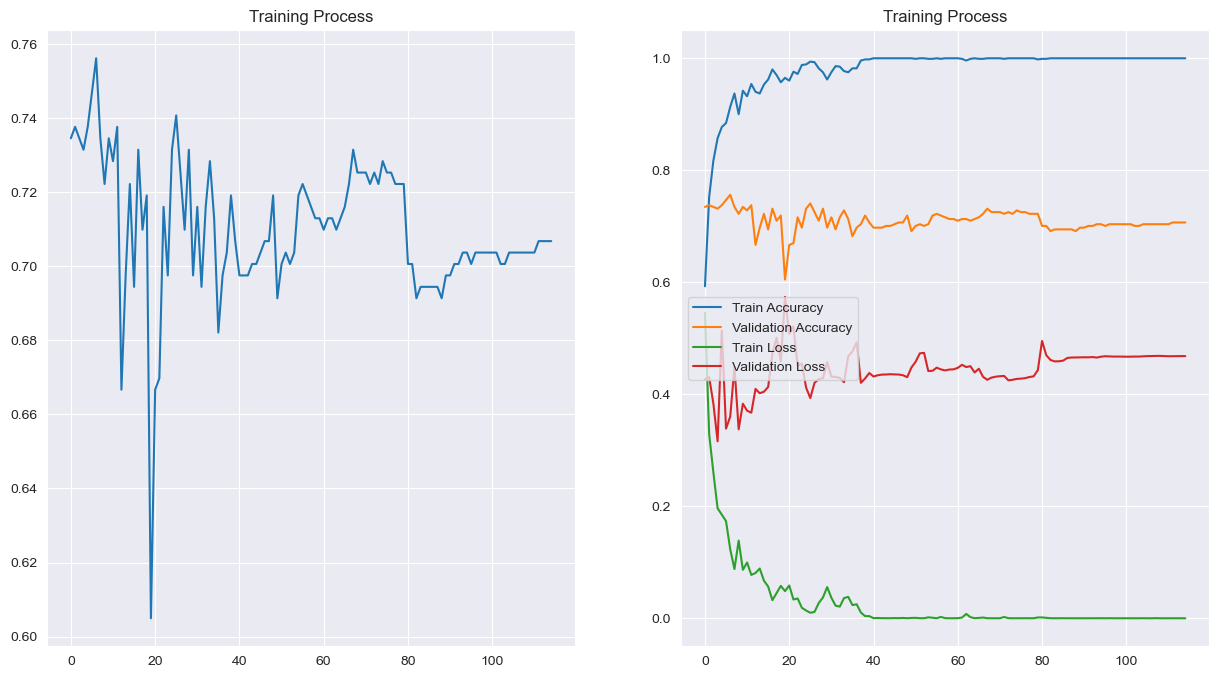

<Figure size 640x480 with 0 Axes>

In [29]:
history=classifier_model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

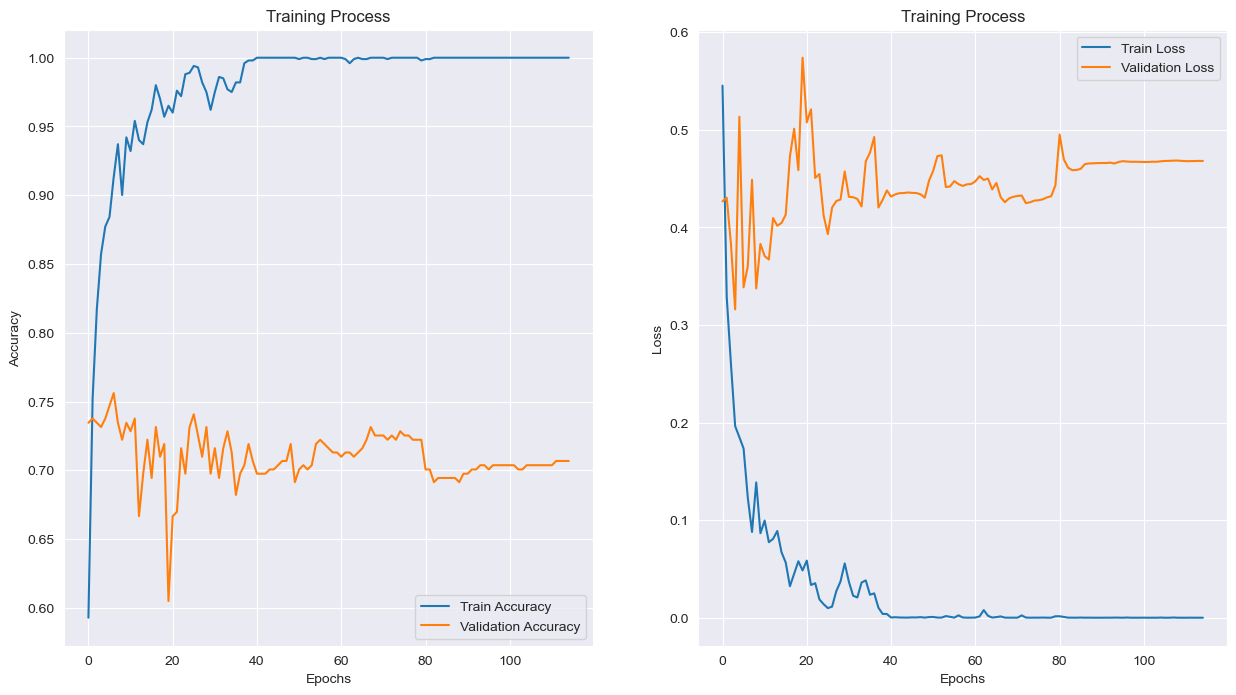

<Figure size 640x480 with 0 Axes>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = classifier_model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [31]:
predictions = classifier_model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 4ms/step


0.7222222222222222

In [32]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7222222222222222
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.58      0.52        85
           0       0.84      0.77      0.80       239

    accuracy                           0.72       324
   macro avg       0.66      0.68      0.66       324
weighted avg       0.74      0.72      0.73       324



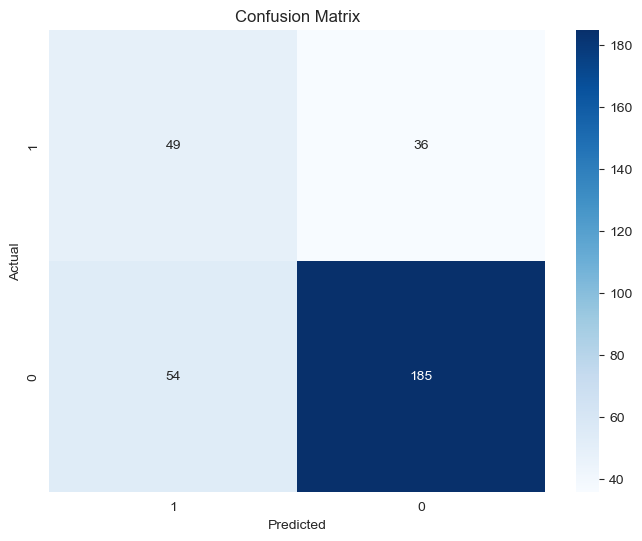

In [34]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

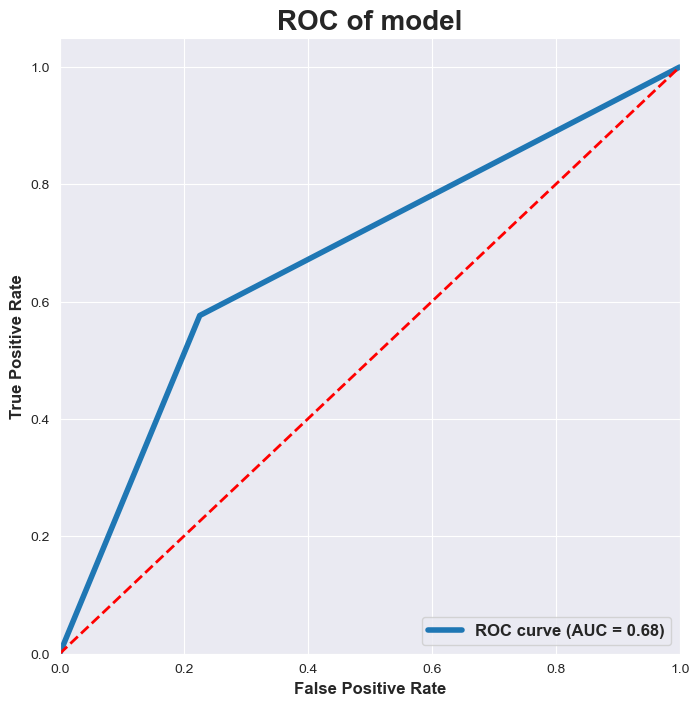

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [36]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [37]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [38]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 234 chiếm khoảng 72.22222222222221% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 49 chiếm khoảng 57.647058823529406% so với thực tế
